# <center>Extractions des données dans les fichiers PDF</center>
L'objectif est d'extraire des informations de plusieurs documents PDF et de les rendre prêtes à être utilisées.


In [1]:
!pip install pdfminer.six

Defaulting to user installation because normal site-packages is not writeable


  ### Importation de librairies neccessaires

In [53]:
import pandas as pd
import seaborn as sns
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import pdfminer
import io
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
from io import BytesIO


In [54]:
name=list()
b_date=list()
out_a=np.empty(0)
out_b=np.empty(0)
pdfFiles=[]

Cette fonction traite chacun des documents PDF et renvoie une chaîne de caractères :

In [55]:
def pdf_to_text(path):
    manager = PDFResourceManager()
    retstr = io.StringIO()
    layout = LAParams(all_texts=True)
    device = TextConverter(manager, retstr)
    filepath = open(path, 'rb')
    interpreter = PDFPageInterpreter(manager, device)
    for page in PDFPage.get_pages(filepath, caching=True, check_extractable=True):
        interpreter.process_page(page)
        text = retstr.getvalue()
    filepath.close()
    device.close()
    retstr.close()
    return text

In [81]:
import PyPDF2

# Choisissez le PDF que vous souhaitez afficher
pdf_file_path = 'Document/EsamiVari_TIZIO_CAIO_5678.pdf'


# Ouvrir le PDF en mode lecture binaire
with open(pdf_file_path, 'rb') as file:
    # Créer un objet de lecteur PDF
    pdf_reader = PyPDF2.PdfReader(file)
    
    # Vérifier le nombre de pages dans le PDF
    num_pages = len(pdf_reader.pages)
    
    # Parcourir chaque page et extraire le texte
    for page_num in range(num_pages):
        # Obtenir l'objet de la page
        page = pdf_reader.pages[page_num]
        
        # Extraire le texte de la page
        text = page.extract_text()
        
        # Afficher le texte extrait
        print(text)

TIZIO CAIO
 Nato/a il 20-02-1970
Richiesta del 20-01-2018
ESAME EMOCROMOCITOMETRICO
Globuli Bianchi (WBC) 4,9x10^3/ul
Globuli Rossi (RBC) 6,0x10^6/ul
Emoglobina (Hgb) 16,0 g/dl
Ematocrito (Hct) 47,0%
Volume Corpuscolare Medio (MCV) 90,0fl
Contenuto Medio Hgb (MCH) 29,0pg
Concentrazione Media Hgb (MCHC) 33,3g/dl
Distribuzione Vol. Eritrocitario (RDW) 13,0%
Piastrine (PLTS) 260x10^3/ul


Ce code enregistre tous les chemins des fichiers PDF dans la liste "pdfFiles".

In [56]:
for dirname, _, filenames in os.walk('Document'):
    for filename in filenames:
        fn = os.path.join(dirname, filename)
        print(fn)
        if fn.endswith('.pdf'):
            pdfFiles.append(fn)

Document\EsamiVari_CAIO_SEMPRONIO_1234.pdf
Document\EsamiVari_TIZIO_CAIO_5678.pdf
Document\EsamiVari_TIZIO_SEMPRONIO_9123.pdf


Voici la fonction qui extrait les informations utiles de la sortie de "pdf_to_text" en utilisant les expressions régulières.

In [57]:
def rgx_pdf(ptr, out):
    ptr = ptr + '\W[0-9]+\W*[0-9]*'
    try:
        a = re.search(ptr, out)[0]
        return re.search('[0-9]+\W*[0-9]*', a)[0]
    except:
        return None

In [58]:
b_date = list()
car = ['WBC', 'RBC', 'Hgb', 'Hct', 'MCV', 'MCH', 'MCHC', 'RDW', 'PLTS']
infos = dict()

for i in np.arange(0, len(car), 1):
    infos[i] = list()

for filename in pdfFiles:
    pageO = pdf_to_text(filename)

    try:
        out = str(pageO)
        sname = re.findall('[A-Z]+\s+[A-Z]+\s', out)[0]
        sdate = re.findall('[0-9]+-[0-9]+-[0-9]+', out)[0]
        name.append(sname)
        b_date.append(sdate)
        i = 0
        for prop in car:
            infos[i].append(rgx_pdf(prop, out))
            i = i + 1
    except (TypeError):
        print("Cannot find nonetype")

In [59]:
df = pd.DataFrame({"Nom": name, "Datte de naissance": b_date})
df2 = pd.DataFrame({car[2]: infos[2]})
i = 0
df2 = pd.DataFrame({car[i]: infos[i]})
df = pd.concat([df, df2], axis=1)

In [60]:
i = 0
while(i < (len(car) - 1)):
    i = i + 1
    print(car[i])
    df2 = pd.DataFrame({car[i]: infos[i]})
    df = pd.concat([df, df2], axis=1)
    del df2


RBC
Hgb
Hct
MCV
MCH
MCHC
RDW
PLTS


In [61]:
df=df.set_index("Nom")
df_=df.iloc[:,1:]
df_=df_.applymap(lambda x: str(x).replace(",",".")).astype("float")
df=pd.concat([df_,df["Date de naissance"]],axis=1)


In [66]:
df.head()

,WBC,RBC,Hgb,Hct,MCV,MCH,MCHC,RDW,PLTS,Data Nascita
Nome Paziente,,,,,,,,,,
CAIO SEMPRONIO,4.8,5.0,15.0,45.0,89.0,27.0,32.3,12.0,220.0,19-01-1980
TIZIO CAIO,4.9,6.0,16.0,47.0,90.0,29.0,33.3,13.0,260.0,20-02-1970
TIZIO SEMPRONIO,5.1,7.0,20.0,50.0,91.0,30.0,35.3,16.0,300.0,20-02-1965


In [64]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3 entries, CAIO SEMPRONIO  to TIZIO SEMPRONIO 
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   WBC     3 non-null      float64
 1   RBC     3 non-null      float64
 2   Hgb     3 non-null      float64
 3   Hct     3 non-null      float64
 4   MCV     3 non-null      float64
 5   MCH     3 non-null      float64
 6   MCHC    3 non-null      float64
 7   RDW     3 non-null      float64
 8   PLTS    3 non-null      float64
dtypes: float64(9)
memory usage: 240.0+ bytes


### exploration des données

In [68]:
#df.to_csv("Emocromo_dset.csv")

In [69]:
df.describe()

,WBC,RBC,Hgb,Hct,MCV,MCH,MCHC,RDW,PLTS
count,3.000000,3.0,3.000000,3.000000,3.0,3.000000,3.000000,3.000000,3.0
mean,4.933333,6.0,17.000000,47.333333,90.0,28.666667,33.633333,13.666667,260.0
std,0.152753,1.0,2.645751,2.516611,1.0,1.527525,1.527525,2.081666,40.0
min,4.800000,5.0,15.000000,45.000000,89.0,27.000000,32.300000,12.000000,220.0
25%,4.850000,5.5,15.500000,46.000000,89.5,28.000000,32.800000,12.500000,240.0
50%,4.900000,6.0,16.000000,47.000000,90.0,29.000000,33.300000,13.000000,260.0
75%,5.000000,6.5,18.000000,48.500000,90.5,29.500000,34.300000,14.500000,280.0
max,5.100000,7.0,20.000000,50.000000,91.0,30.000000,35.300000,16.000000,300.0


<Axes: >

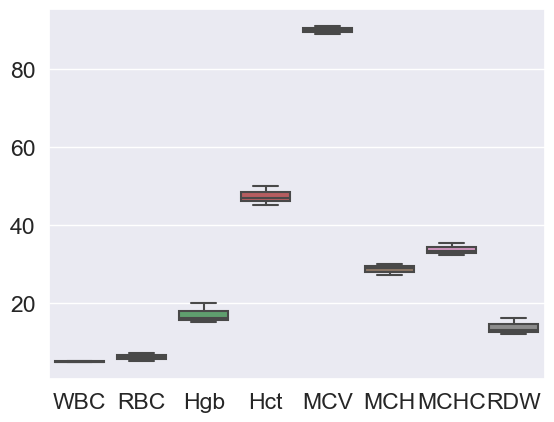

In [70]:
sns.boxplot(data=df.iloc[:,:8],orient="v")

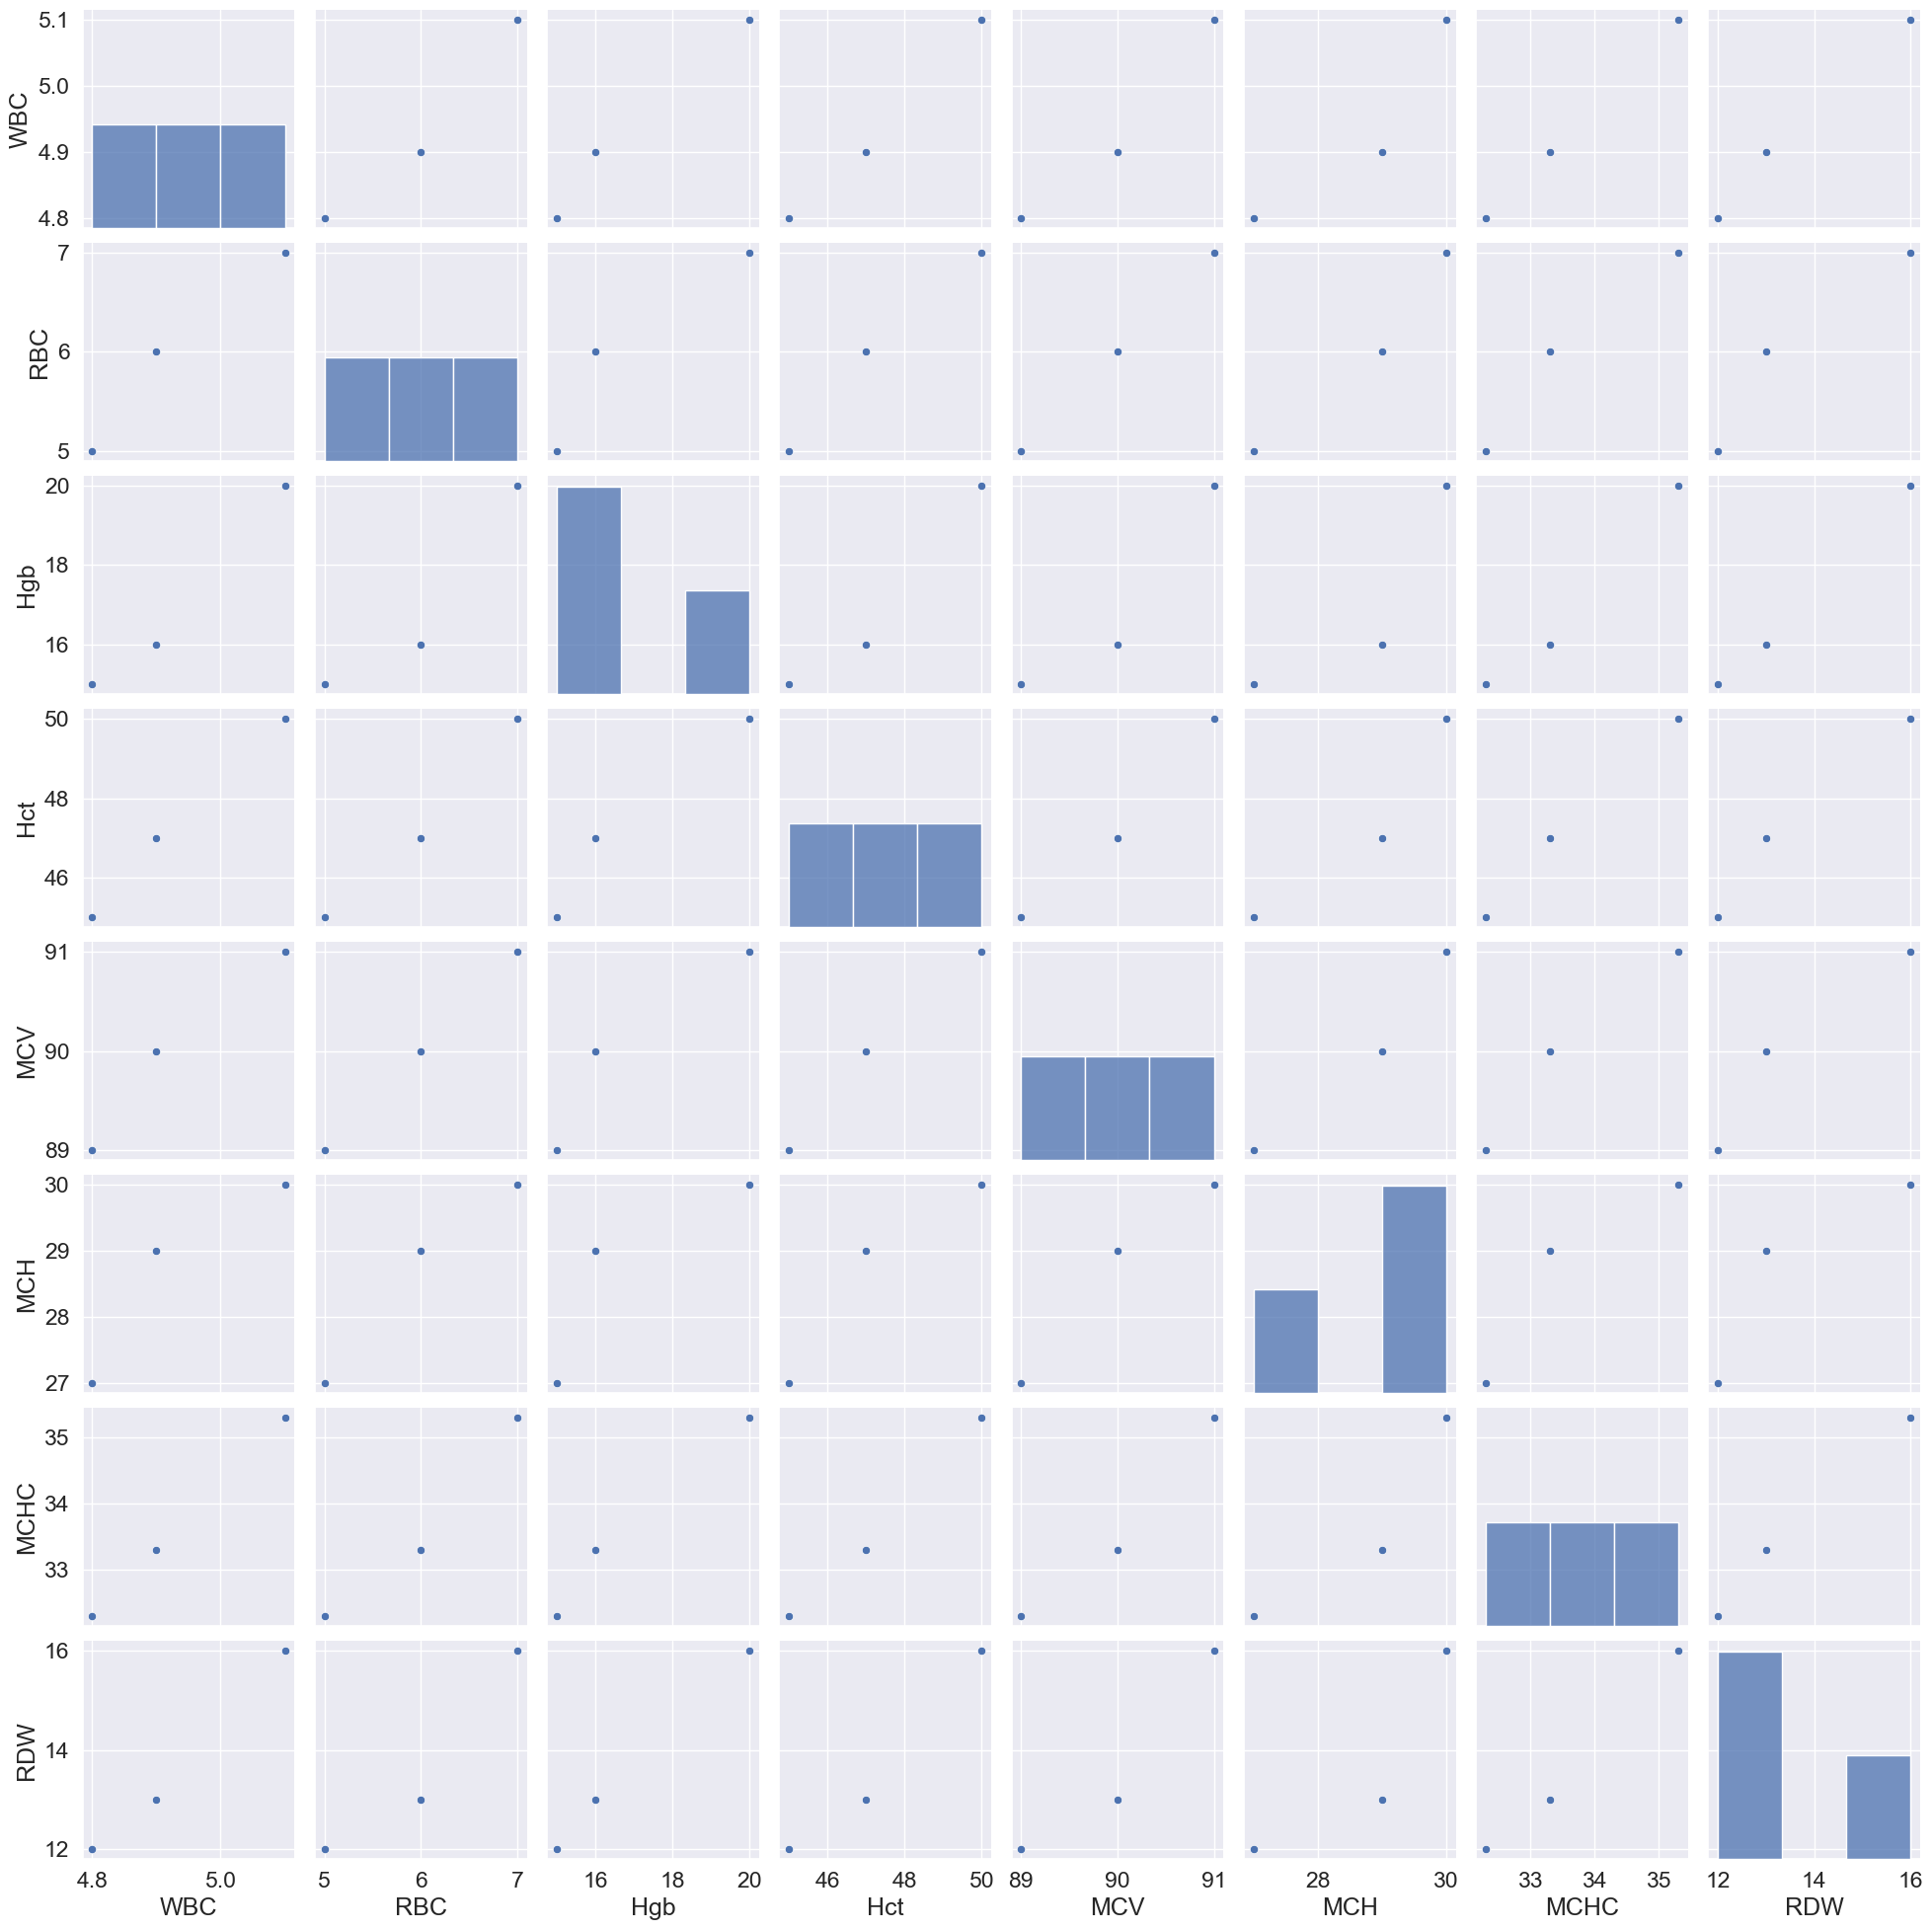

In [71]:
sns.pairplot(df.iloc[:,:8],height=2.5)

In [72]:
cm=np.corrcoef(df.iloc[:,:9].values.T)

In [73]:
sns.set(font_scale=1.5)

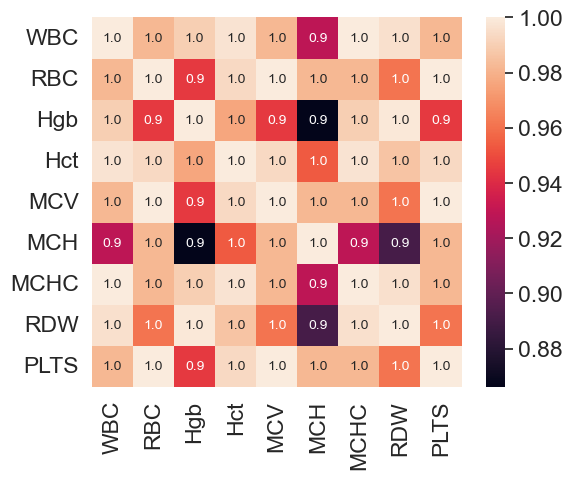

In [74]:
hm=sns.heatmap(cm,cbar=True,annot=True,square=True,fmt='.1f',annot_kws={'size':10},yticklabels=df.iloc[:,:9].columns,xticklabels=df.iloc[:,:9].columns)

###  Merci !!!!